# Staff Scheduling For Stochastic Demands
In this article, I'll introduce a simple and efficient model for solving a staff scheduling problem.

## Motivation and Problem Definition
Imagine that Alice owns a restaurant. Her awesome fashion restaurant aims to provide great dishes all day long, and she plans to hire some people to run the restaurant. Since this is an awesome fashion restaurant, Alice requires that all chefs have to be professionally trained, and so do the servers. Some employees are more properly trained so that they can be either a chef or a server, but they can't do both at the same time since that's unsanitary and keep changing jobs make the employees angry. In fact, since employees hate changing jobs all the time, we want to add some penalties to compensate for the loss in employees' emotions. The whole day is divided into 8 shifts, each shift is 6-hour-long, and the nearby two shifts have three-hour-long overlaps. 

While this is a hypothesis scenario for staff scheduling, the model I'll represent can use for more scenarios. For example, consider, again, a restaurant that provides two special ingredients that require some certain equipment to cook, but a specific type of equipment can cook both, such as the rice cooker (?). Moreover, those pieces of equipment can't be used continuously for too long, or they may break early.

## Basic Model
Here I'll present a simple model to solve the problem above. Before diving into the model itself, we need to define some parameters:


| Set  | Definition                                  |
| ---- | ------------------------------------------- |
| $I$  | Schedules of when to work and when to leave |
| $J$  | Set of jobs                                 |
| $T$  | Time period in a day, $T = {0,...,23}$      |


| Parameter | Definition                                                   |
| --------- | ------------------------------------------------------------ |
| $A_{it}$  | Schedule $i$ include period $t$ or not (binary)              |
| $D_{jt}$  | Demand of worker needed on job $j$ at period $t$\\           |
| $E_{j}$   | Number of workers who have the skill for job $j$             |
| $B$       | Number of workers who have both skills, $B < E_j$            |
| $C_{t}$   | Cost of hiring a worker to work at period $t$                |
| $F$       | Cost of letting a worker change jobs at the middle of a day  |

| Decision Variable | Definition                                                   |
| ----------------- | ------------------------------------------------------------ |
| $x_{i}$           | Number of worker work on schedule $i$ (integer)              |
| $y_{jt}$          | Number of worker work on job $j$ on period $t$ (integer)     |
| $z_{jt}$          | Difference of number of workers on job $j$ at the start of period $t$ (integer) |

The definition above is quite straightforward, I believe. Then, we'll formulate the model step by step.
First of all, Alice's main goal is to minimize the personnel costs of running her restaurant, so the objective function would be the cost of hiring her employees and the cost of making her employees change their jobs.

$$
\min \sum_{j \in J} \sum_{t \in T} y_{jt} C_{t} + \sum_{t \in T}\sum_{j \in J} z_{jt} F
$$

Then, at each period, the number of staff on duty has to equal the number of staff assigned to the schedules which contain that period.
$$
\sum_{j \in J} y_{jt} = \sum_{i \in I} x_{i} A_{it} \quad \forall t \in T
$$
Okay, I know this might sound redundant or useless, but I'll show how it can be useful in the extended problem.

Most importantly, the number of staff on duty must be larger or equal to the demands, otherwise, the staff would be too busy and resign.
$$
y_{jt} \geq D_{jt} \quad \forall j \in J,\ t \in T
$$

At each period, the number of staff on duty must be smaller than the total staff the restaurant hired.
$$
\sum_{i \in I} x_{i} \leq \sum_{j \in J} E_j  - B
$$

Similarly, the number of staff on duty with a certain skill should not exceed the number of employees with that skill. For example, Alice can't assign 20 chefs to work if she only hires 10 chefs.
$$
y_{jt} \leq E_j \quad \forall j \in J,\ t \in T
$$

Finally, we want to define $z$ as the number of job changes between periods.
$$
z_{jt} = \mid y_{jt} - y_{j,t-1} \mid \quad \forall j \in J,\ t \in \{1,...23\}
$$

Then, the range of all variables must be non-negative.
$$
x_i, y_{jt}, z_{jt}, r_{jt} \geq 0 \quad \forall i,j,t
$$

In [5]:
from IPython.display import display, Math, Latex

The complete model would be:

\begin{align}
    \min \quad 
    &  \sum_{j \in J} \sum_{t \in T} y_{sjt} C_{t}  % hiring cost
        + \sum_{t \in T}\sum_{j \in J} z_{sjt} F \\ % change job cost
    % constraints
    \mbox{s.t.} \quad 
    % 分配到工作的人數要符合上班人數
    & \sum_{j \in J} y_{jt} = \sum_{i \in I} x_{i} A_{it}
        & \forall t \in T\\  
    % 值班人數要滿足需求
    & y_{jt} \geq D_{jt} 
        & \forall j \in J,\ t \in T\\  
    % 總上班人數 <= 總員工數 
    & \sum_{i \in I} x_{i} \leq \sum_{j \in J} E_j  - B\\ 
    % 任一時段，每個技能的值班人數 <= 總持有技能人數
    & y_{jt} \leq E_j 
        & \forall j \in J,\ t \in T\\  
    % 任一時段，外包人數 <= 外包上限
    & l_{jt} \leq L_{jt} 
        & \forall j \in J,\ t \in T\\  
    % 定義 z: 轉換次數
    & z_{jt} = \mid y_{jt} - y_{j,t-1} \mid
        & \forall j \in J,\ t \in \{1,...23\}\\  % 中途轉換次數(取絕對值)
    & x_i, y_{jt}, z_{jt}, r_{jt} \geq 0 & \forall i,j,t
\end{align}

## Weighted Sum Method
So far so good, until one day Alice realized that the restaurant's demand can't be accurately predicted. In particular, she found that the demand is quite low on rainy days because people would rather stay home, and the demand is high on pleasant days. Fortunately, the weather forecast is quite well so that she knows the probability distribution of the weather tomorrow. She then wants to consider all scenarios, instead of betting on which scenario would realize, and decide how many employees have to work tomorrow.

We'll start with adding a set $S$ indicating all scenarios and change the definition of the parameters and decision variables.

| Set  | Definition                                  |
| ---- | ------------------------------------------- |
| $I$  | Schedules of when to work and when to leave |
| $J$  | Set of jobs, $|J| = 2$                      |
| $T$  | Time period in a day, $T = {0,...,23}$      |

| Parameter | Definition                                                   |
| --------- | ------------------------------------------------------------ |
| $A_{it}$  | Schedule $i$ include period $t$ or not (binary)              |
| $D_{jt}$  | Demand of worker needed on job $j$ at period $t$\\           |
| $E_{j}$   | Number of workers who have the skill for job $j$             |
| $B$       | Number of workers who have both skills, $B < E_j$            |
| $C_{t}$   | Cost of hiring a worker to work at period $t$                |
| $F$       | Cost of letting a worker change jobs at the middle of a day  |

| Decision Variable | Definition                                                   |
| ----------------- | ------------------------------------------------------------ |
| $x_{i}$           | Number of worker work on schedule $i$ (integer)              |
| $y_{sjt}$         | Number of worker work on job $j$ on period $t$ in scenario $s$ (integer) |
| $z_{sjt}$         | Number of worker changing job at the start of period $t$ in scenario $s$ (integer) |

In the objective functions, we want to take all scenarios into consideration. More specifically, we want to optimize the expected value of the cost in all scenarios.
$$
\min \sum_{s \in S} P_s  (\sum_{j \in J} \sum_{t \in T} y_{jt} C_{t} + \sum_{t \in T}\sum_{j \in J} z_{jt} F)
$$
The remaining is quite the same, except we now need to consider more scenarios. The full model is shown as below:

\begin{align}
    % objective: min cost
    \min \quad 
    & \sum_{s \in S} P_s 
    \left( \sum_{j \in J} \sum_{t \in T} y_{sjt} C_{t}  % hiring cost
        + \sum_{t \in T}\sum_{j \in J} z_{sjt} F \right) \\ % change job cost
    % constraints
    \mbox{s.t.} \quad 
    % 分配到工作的人數要符合上班人數
    & \sum_{j \in J} y_{sjt} = \sum_{i \in I} x_{i} A_{it}
        & \forall t \in T, \ s \in S\\  
    % 值班人數要滿足需求
    & y_{sjt} \geq D_{sjt} 
        & \forall j \in J,\ t \in T, \ s \in S\\  
    % 總上班人數 <= 總員工數 
    & \sum_{i \in I} x_{i} \leq \sum_{j \in J} E_j  - B\\ 
    % 任一時段，每個技能的值班人數 <= 總持有技能人數
    & y_{sjt} \leq E_j 
        & \forall j \in J,\ t \in T, \ s \in S\\  
    % 定義 z: 轉換次數
    & z_{sjt} = \mid y_{sjt} - y_{s,j,t-1} \mid
        & \forall j \in J,\ t \in \{1,...23\}, \ s \in S\\  % 中途轉換次數(取絕對值)
    & x_i, y_{sjt}, z_{st}, r_{sjt} \geq 0 & \forall i,j,t,s
\end{align}

## Outsourcing
However, you might notice that the model above is quite useless because it always tries to satisfy the highest demand in each period. This is as a matter of course, for Alice does not allow lack of labor, so the model always tries to find a distribution of labor force that satisfies all scenarios. While in some extreme cases, overestimating the required labor forces may help since the highest possible demand might realize, in most cases, this is just a waste of money. To solve this issue, Alice decided that she can accept outsourcing, that is, if in the morning of a day, Alice found that the demand is higher than expected, she can call for help, and a group of poor students will come to her restaurants and help. Of course, the cost of hiring the students temporarily is higher than the cost of existing employees, otherwise, she can always call the students for help, instead of hiring the employees herself.

As a side note, the idea of "outsourcing" does not need to be actually hiring people, you can also interpret it as the penalty for lack of labor.

We add two new parameters $L_{jt}$, indicating the upper bound of outsourcing workers with the skill for job $j$ on period $t$, and its cost $G_{jt}$. In addition, we add a new decision variable $l_{sjt}$ to decide how many outsourcing workers on job $j$, period $t$ in scenario $s$.

| Parameter | Definition                                                   |
| --------- | ------------------------------------------------------------ |
| $A_{it}$  | Schedule $i$ include period $t$ or not (binary)              |
| $D_{jt}$  | Demand of worker needed on job $j$ at period $t$\\           |
| $E_{j}$   | Number of workers who have the skill for job $j$             |
| $L_{jt}$  | Number of outsourcing workers who have the skill for job $j$ on period $t$ |
| $B$       | Number of workers who have both skills, $B < E_j$            |
| $C_{t}$   | Cost of hiring a worker to work at period $t$                |
| $F$       | Cost of letting a worker change jobs at the middle of a day  |
| $G_{jt}$  | Cost of satisfied an unit of demand by outsourcing           |

| Decision Variable | Definition                                                   |
| ----------------- | ------------------------------------------------------------ |
| $x_{i}$           | Number of worker work on schedule $i$ (integer)              |
| $y_{sjt}$         | Number of worker work on job $j$ on period $t$ in scenario $s$ (integer) |
| $z_{sjt}$         | Number of worker changing job at the start of period $t$ in scenario $s$ (integer) |
| $l_{sjt}$         | Number of outsourcing on job $j$, period $t$ in scenario $s$ |

We'll first change the definition of the objective functions, taking the cost of outsourcing into account.

$$
\sum_{s \in S} P_s ( \sum_{j \in J} \sum_{t \in T} y_{sjt} C_{t}+ \sum_{t \in T}\sum_{j \in J} l_{sjt}G_{jt} + \sum_{t \in T}\sum_{j \in J} z_{sjt} F)
$$

The constraints also have to be slightly modified. To satisfy the demand, the summation of employees on duty and the outsourcing workers on duty have to be larger or equals to 

$$
y_{sjt} + l_{sjt} \geq D_{sjt} \quad \forall j \in J,\ t \in T, \ s \in S\\  
$$

Remind that we need to first decide how many employees have to be on duty before learning the actual scenario, but we can postpone the decision of hiring the outsourcing workers until we learn the actual scenario.

Then, the range of $l_{sjt}$.
$$
l_{sjt} \leq L_{jt} \quad \forall j \in J,\ t \in T, \ s \in S
$$

The full model is shown as follows.

\begin{align}
    % objective: min cost
    \min \quad 
    & \sum_{s \in S} P_s 
    \left( \sum_{j \in J} \sum_{t \in T} y_{sjt} C_{t}  % hiring cost
        + \sum_{t \in T}\sum_{j \in J} l_{sjt}G_{jt}  % outsourcing
        + \sum_{t \in T}\sum_{j \in J} z_{sjt} F \right) \\ % change job cost
    % objective: max redundant
    \max \quad 
        & \sum_{s \in S} P_s \left( \sum_{j \in J} \sum_{t \in T} r_{sjt} \right)\\
    % objective: min variance of redundant
    %\min \quad 
    %    & \sum_{s \in S} P_s \left( \sum_{j \in J} \sum_{t \in T} (r_{sjt} - \overline{r})^2 \right)\\
    % constraints
    \mbox{s.t.} \quad 
    % 分配到工作的人數要符合上班人數
    & \sum_{j \in J} y_{sjt} = \sum_{i \in I} x_{i} A_{it}
        & \forall t \in T, \ s \in S\\  
    % 值班人數要滿足需求
    & y_{sjt} + l_{sjt} \geq D_{sjt} 
        & \forall j \in J,\ t \in T, \ s \in S\\  
    % 定義 r: redundant (恆正)
    & r_{sjt} = y_{sjt} + l_{sjt} - D_{sjt}
        & \forall j \in J,\ t \in T, \ s \in S\\
    % 總上班人數 <= 總員工數 
    & \sum_{i \in I} x_{i} \leq \sum_{j \in J} E_j  - B\\ 
    % 任一時段，每個技能的值班人數 <= 總持有技能人數
    & y_{sjt} \leq E_j 
        & \forall j \in J,\ t \in T, \ s \in S\\  
    % 任一時段，外包人數 <= 外包上限
    & l_{sjt} \leq L_{jt} 
        & \forall j \in J,\ t \in T, \ s \in S\\  
    % 定義 r 的平均值
    & \overline{r} = \sum_{s \in S}\sum_{j \in J}\sum_{t \in T} r_{sjt}\ /\ (S \times J \times T)\\
    % 定義 z: 轉換次數
    & z_{sjt} = \mid y_{sjt} - y_{s,j,t-1} \mid
        & \forall j \in J,\ t \in \{1,...23\}, \ s \in S\\  % 中途轉換次數(取絕對值)
    & x_i, y_{sjt}, z_{st}, r_{sjt} \geq 0 & \forall i,j,t,s
\end{align}

## 2-Stage Recourse
While the weighted-sum method mentioned above is good, we can further improve it by postponing the decision. More specifically, we can separate the model into two stages. In the first stage, we only know the probability distribution of the scenario, and we want to decide how many workers have to be on duty. In the second stage, we already learn the actual scenario and have to decide who has to work at which periods, and whether we need outsourcing. This is called the "2-stage recourse" method.

In the first stage, we only decide $x$, the expected number of workers on duty.

\begin{align}
    \min \quad & \sum_{i \in I} \sum_{t \in T} x_{i} A_{it} C_{t}  % hiring cost
    + \mathbb{E}(\pi_s \mid s \in S)\\
    \mbox{s.t.} \quad
    % % enough manpower
    % & \sum_{i \in I} x_{i} A_{it} \geq \sum_{j \in J} D_{sjt}
    %     & \forall t \in T\\ % 各時段上班人數 >= 所需人數
    & x_i \geq 0 & \forall i \in I
\end{align}

The $\pi$ is the output of the second stage model given the scenario $s$. We need to calculate the expected value of cost given by the second stage models, and optimize $x$ according to it.

In the second stage, we already know the actual scenario, it is at this point that we assign the employees to jobs and hire the outsourcing workers if required.

\begin{align}
    \min \quad & \pi_s = \sum_{t \in T}\sum_{j \in J} z_{sjt} F % change job cost
        + \sum_{t \in T} \sum_{j \in J} l_{sjt} G_{jt}\\
    \mbox{s.t.} \quad 
    % constraint
    & \sum_{j \in J} y_{sjt} = \sum_{i \in I} x_{i} A_{it}
        & \forall t \in T\\  % 各時段分配到工作的人數要符合上班人數
    & y_{sjt} + l_{sjt} \geq D_{sjt} 
        & \forall j \in J,\ t \in T\\  % 值班加外包要能滿足需求
    & y_{sjt} \leq E_j 
        & \forall j \in J,\ t \in T\\  % 任一時段，每個技能的值班人數 <= 總持有技能人數
    & l_{sjt} \leq L_{jt} 
        & \forall j \in J,\ t \in T\\  % 任一時段，外包人數 <= 上限    
    & z_{sjt} = \mid y_{sjt} - y_{s,j,t-1} \mid
        & \forall j \in J,\ t \in \{1,...23\} 
        \label{s.t.absolute}\\  % 中途轉換次數(取絕對值)
    & x_i, y_{sjt}, z_{st}, r_{sjt}, l_{sjt} \geq 0 & \forall i,j,t
\end{align}

Notice that in the second stage model, the $s$ is actually fixed, since we've learned the scenario.

## Simulation
Alice is now satisfied with the model. However, before applying to her awesome fashion restaurant, she wants to prove that this model is efficient. Therefore, we need to run several simulations.

In the most simple case, assuming that the number of customers is a bell shape. We first need to generate a demand that is bell-shaped.

(array([ 3,  5,  6,  9, 11, 14, 16, 19, 22, 24, 26, 27, 27, 27, 26, 24, 22,
        19, 16, 14, 11,  9,  6,  5]),
 [<matplotlib.lines.Line2D at 0x7f66a5056668>])

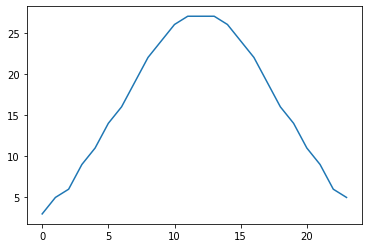

In [21]:
from scipy.stats import norm
import random
import numpy as np
import matplotlib.pyplot as plt
def demand_generation_normal(length):
    a = np.array(range(0, length)) - length // 2
    a = a / 6
    return (norm().pdf(a) * 70).astype(int)
demand_generation_normal(24), plt.plot(demand_generation_normal(24))

Looks good. But as mentioned, there are several scenarios, and we need to create several possible ones. In each scenario, the height, the center, and the variance of the bell shapes can be different. We'll try to randomly generate severals.

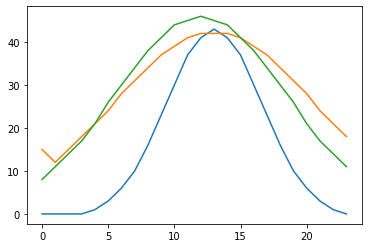

In [31]:
def demand_generation_normal(length, offset=0, do_random=False):
    a = np.roll(np.array(range(0, length)) - length // 2, offset if not do_random else int(random.uniform(-2, 2))) 
    a = a / ( random.uniform(3, 9) if do_random else 6 )
    return (norm().pdf(a) * ( random.uniform(80, 120) if do_random else 100 )).astype(int)
plt.plot(demand_generation_normal(24, do_random=True))
plt.plot(demand_generation_normal(24, do_random=True))
plt.plot(demand_generation_normal(24, do_random=True))

We can now see several different demands in different scenarios. After having this demand generator, we can run the simulation.
For example, we now have three scenarios of demand with equal probability:
$$
s_{low}, j_1=[1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, 9, 9, 8, 7, 7, 6, 5, 4, 3, 2, 1] \\
s_{low}, j_2=[1, 1, 1, 2, 3, 4, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7, 6, 5, 4, 4, 3, 2, 1, 1] \\
s_{mid}, j_1=[ 8, 10, 12, 14, 15, 17, 18, 19, 19, 19, 18, 17, 15, 14, 12, 10,  8, 6,  4,  3,  2,  3,  4,  6] \\
s_{mid}, j_2=[ 6,  4,  3,  2,  2,  2,  3,  4,  6,  8,  9, 11, 12, 14, 14, 15, 15, 15, 14, 14, 12, 11,  9,  8] \\
s_{high}, j_1=[23, 26, 27, 29, 29, 29, 27, 26, 23, 21, 18, 15, 12,  9,  6,  5,  3, 5,  6,  9, 12, 15, 18, 21] \\
s_{high}, j_2=[18, 16, 14, 12,  9,  7,  5,  4,  3,  4,  5,  7,  9, 12, 14, 16, 18, 21, 22, 23, 23, 23, 22, 21] \\
$$

The simulation of the basic model gives $x=[9.0, 32.0, 0, 28, 0, 26, 9, 32]$, with the cost 8,476.

The simulation of two-stage recourse method gives $x = [9, 32, 0, 28, 0, 26, 9, 32]$.

| Scenario | Cost  | Outsourcing |
| -------- | ----- | ----------- |
| Low      | 8,310 | 0           |
| Mid      | 8,370 | 0           |
| High     | 8,750 | 2           |

We can see that the model actually decided to assign fewer workers and use outsourcing in high demands. In addition, in the low and mid scenarios, the cost is lower. 

---

But one example doesn't speak much, we then run the simulation 100 times. The basic model gives the average cost of 8,946.28, and the average outsourcing of 22.5.

And the two-stage recourse model gives:

| Scenario | Average Cost | Average Outsourcing |
| -------- | ------------ | ------------------- |
| Low      | 8117.35      | 0                   |
| Mid      | 8409.35      | 2.62                |
| High     | 11191.65     | 29.42               |

---

The above simulation assumes that the possibilities of all scenarios are the same. If the probability is also randomized, the basic model gives the expected cost of 8651.13, and the outsourcing amount of 43.35. The two-stage recourse model gives:

| Scenario | Average Cost | Average Outsourcing |
| -------- | ------------ | ------------------- |
| Low      | 7655.4       | 0.02                |
| Mid      | 8230.0       | 5.45                |
| High     | 11228.7      | 34.34               |

Notice that the basic model still often overestimate the labor force needed, and the two-stage recourse model can postpone the decision so that it usually performs better. Hope that Alice likes this model.

## Conclusion
This simple model shows how integer programming can be used for scheduling problems under stochastic demands. We also demonstrated that the model is efficient in terms of optimizing the cost. However, optimizing the cost may not be the only objective. In fact, my teammate wrote another tutorial, showing that how one can further enhance this model by the epsilon constraints. The link will be provided later.

Most of our model is based on the implementation of [1], but to simplify the problem, I removed the multi-criteria parts (which, as I mentioned, is covered by my teammate) and use the traditional integer programming method instead of the genetic algorithm. I hope this article helps readers understand how elegant the solutions provided by Operations Research are.

This article is the final project of [Operations Research Applications and Implementation](https://nol.ntu.edu.tw/nol/coursesearch/print_table.php?course_id=725%20U3690&class=&dpt_code=7050&ser_no=64554&semester=109-2&lang=CH) at Dept. of Information Management, National Taiwan University, in partnership with Ting Lin, under the supervision of Prof. Lee.

All the code used in this tutorial is open-sourced and published at [the GitHub repo](https://github.com/s3131212/Staff-Scheduling-For-Stochastic-Demands).

## Reference
[1] Cai, X. & Li, K. N., 2000. "A genetic algorithm for scheduling staff of mixed skills under multi-criteria," European Journal of Operational Research, Elsevier, vol. 125(2), pages 359-369, September. 